#### This notebook will discuss the GANs

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

print("Path to dataset files:", path)

/home/arifuz/Projects/AI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 52.9M/52.9M [00:49<00:00, 1.11MB/s]

Extracting files...


Path to dataset files: /home/arifuz/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1


In [3]:
DATA_DIR = path
image_size = 64
batch_size = 256
states = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [4]:
train_ds =ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*states)
]))


train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)

In [5]:
import torch 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
def denorm(img_tensors):
    return img_tensors * states[1][0] + states[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), 
                        nrow=8).permute(1,2,0))

def show_batch(d1,nmax=64):
    for images, _ in d1:
        show_images(images, nmax)
        break


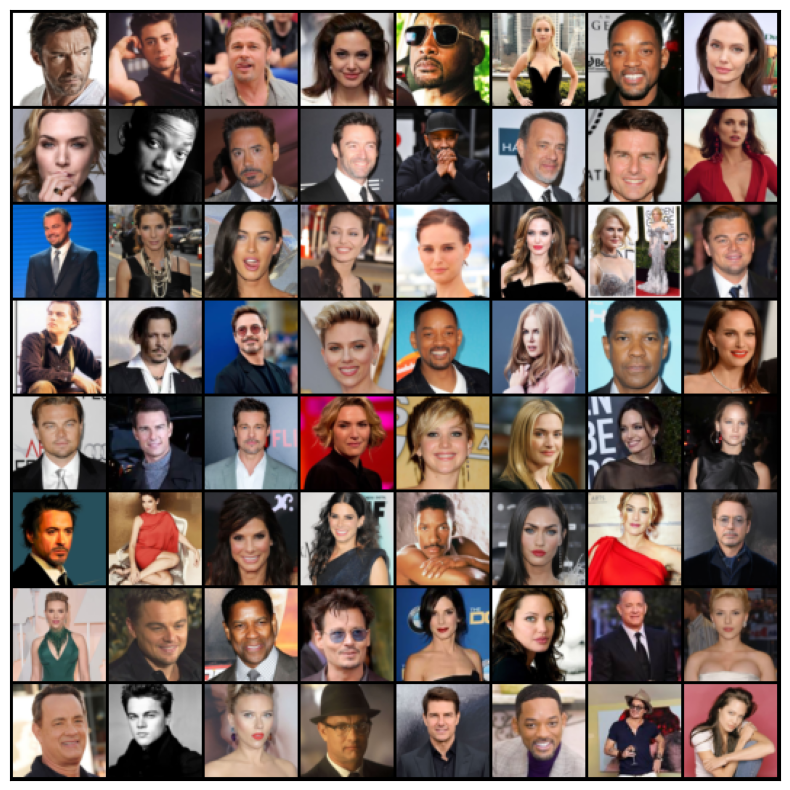

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, d1, device):
        self.d1=d1
        self.device = device
    
    def __iter__(self):
        for b in self.d1:
            yield to_device(b, self.device)

        def __len__(self):
            return len(self.d1)

In [10]:
device = get_default_device()
device

device(type='cpu')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()


)

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()


)

In [19]:
generator = to_device(generator, device)

In [21]:
import torch.nn.functional as F
def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()
    real_preds =discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0),1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    #opt_d.stop()
    return loss.item(), real_score, fake_score

In [22]:
import torch.nn.functional as F
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_image = generator(latent)

    preds = discriminator(fake_image)
    targets = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    #opt_g.stop()

    return loss.item()

In [23]:
from torchvision.utils import save_image

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_image_{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [26]:
fixed_latent = torch.rand(64, latent_size, 1,1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999692..0.9997171].


Saving generated_image_0000.png


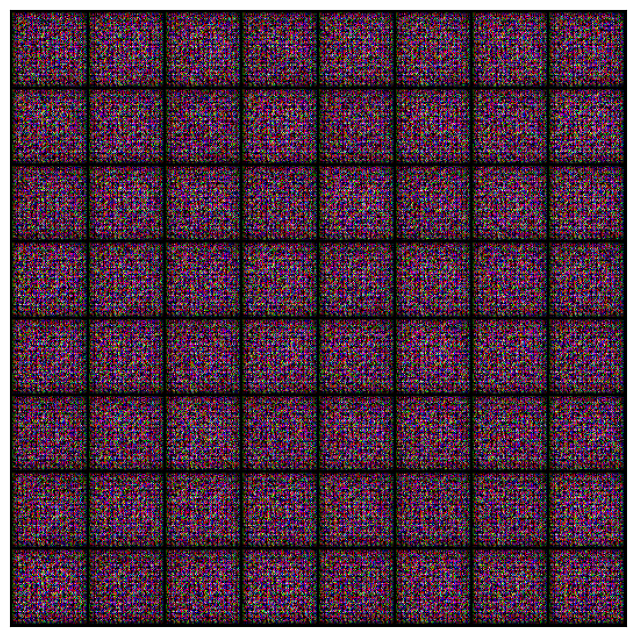

In [27]:
save_samples(0,fixed_latent)

In [28]:
from tqdm import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()


    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)



        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score
        ))

        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores



In [31]:
!pip3 install IProgress
!pip3 install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 889.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.1 MB/s eta 0:00:0000:0100:010m


In [32]:
%%time
lr = 0.005
epochs = 40 #to get better result need to update this to 500 but will take huge huge time
history = fit(epochs, lr)

8it [00:38,  4.87s/it]


Epoch [1/40], loss_g: 0.6349, loss_d: 1.3223, real_score: 0.5921, fake_score: 0.5386
Saving generated_image_0001.png


8it [00:45,  5.66s/it]


Epoch [2/40], loss_g: 0.6212, loss_d: 1.4347, real_score: 0.5361, fake_score: 0.5396
Saving generated_image_0002.png


8it [00:46,  5.77s/it]


Epoch [3/40], loss_g: 0.6343, loss_d: 1.3872, real_score: 0.5631, fake_score: 0.5421
Saving generated_image_0003.png


8it [00:45,  5.72s/it]


Epoch [4/40], loss_g: 0.6400, loss_d: 1.4435, real_score: 0.5236, fake_score: 0.5367
Saving generated_image_0004.png


8it [00:44,  5.60s/it]


Epoch [5/40], loss_g: 0.6256, loss_d: 1.4047, real_score: 0.5442, fake_score: 0.5326
Saving generated_image_0005.png


8it [00:45,  5.71s/it]


Epoch [6/40], loss_g: 0.6413, loss_d: 1.3502, real_score: 0.5839, fake_score: 0.5446
Saving generated_image_0006.png


8it [00:45,  5.73s/it]


Epoch [7/40], loss_g: 0.6544, loss_d: 1.3859, real_score: 0.5510, fake_score: 0.5335
Saving generated_image_0007.png


8it [00:45,  5.68s/it]


Epoch [8/40], loss_g: 0.6430, loss_d: 1.4072, real_score: 0.5457, fake_score: 0.5411
Saving generated_image_0008.png


8it [00:46,  5.77s/it]


Epoch [9/40], loss_g: 0.6317, loss_d: 1.4699, real_score: 0.5167, fake_score: 0.5380
Saving generated_image_0009.png


8it [00:45,  5.74s/it]


Epoch [10/40], loss_g: 0.6201, loss_d: 1.3148, real_score: 0.5997, fake_score: 0.5432
Saving generated_image_0010.png


8it [00:45,  5.66s/it]


Epoch [11/40], loss_g: 0.6531, loss_d: 1.4377, real_score: 0.5376, fake_score: 0.5390
Saving generated_image_0011.png


8it [00:49,  6.24s/it]


Epoch [12/40], loss_g: 0.6154, loss_d: 1.3365, real_score: 0.5922, fake_score: 0.5453
Saving generated_image_0012.png


8it [00:50,  6.34s/it]


Epoch [13/40], loss_g: 0.6399, loss_d: 1.4609, real_score: 0.5113, fake_score: 0.5275
Saving generated_image_0013.png


8it [00:50,  6.37s/it]


Epoch [14/40], loss_g: 0.6449, loss_d: 1.3626, real_score: 0.5617, fake_score: 0.5297
Saving generated_image_0014.png


8it [00:50,  6.29s/it]


Epoch [15/40], loss_g: 0.6446, loss_d: 1.4169, real_score: 0.5513, fake_score: 0.5438
Saving generated_image_0015.png


8it [00:49,  6.15s/it]


Epoch [16/40], loss_g: 0.6201, loss_d: 1.4117, real_score: 0.5399, fake_score: 0.5362
Saving generated_image_0016.png


8it [00:49,  6.23s/it]


Epoch [17/40], loss_g: 0.6515, loss_d: 1.4121, real_score: 0.5416, fake_score: 0.5353
Saving generated_image_0017.png


8it [00:50,  6.29s/it]


Epoch [18/40], loss_g: 0.6172, loss_d: 1.3604, real_score: 0.5794, fake_score: 0.5449
Saving generated_image_0018.png


8it [00:50,  6.31s/it]


Epoch [19/40], loss_g: 0.6420, loss_d: 1.4108, real_score: 0.5388, fake_score: 0.5293
Saving generated_image_0019.png


8it [00:50,  6.29s/it]


Epoch [20/40], loss_g: 0.6289, loss_d: 1.4241, real_score: 0.5519, fake_score: 0.5412
Saving generated_image_0020.png


8it [00:49,  6.19s/it]


Epoch [21/40], loss_g: 0.6334, loss_d: 1.2520, real_score: 0.6331, fake_score: 0.5385
Saving generated_image_0021.png


8it [00:49,  6.18s/it]


Epoch [22/40], loss_g: 0.6332, loss_d: 1.3317, real_score: 0.5787, fake_score: 0.5344
Saving generated_image_0022.png


8it [00:49,  6.24s/it]


Epoch [23/40], loss_g: 0.6468, loss_d: 1.4711, real_score: 0.5174, fake_score: 0.5394
Saving generated_image_0023.png


8it [00:50,  6.29s/it]


Epoch [24/40], loss_g: 0.6323, loss_d: 1.3742, real_score: 0.5569, fake_score: 0.5365
Saving generated_image_0024.png


8it [00:49,  6.22s/it]


Epoch [25/40], loss_g: 0.6233, loss_d: 1.3839, real_score: 0.5547, fake_score: 0.5383
Saving generated_image_0025.png


8it [00:48,  6.01s/it]


Epoch [26/40], loss_g: 0.6470, loss_d: 1.3771, real_score: 0.5648, fake_score: 0.5396
Saving generated_image_0026.png


8it [00:44,  5.57s/it]


Epoch [27/40], loss_g: 0.6412, loss_d: 1.4706, real_score: 0.5297, fake_score: 0.5455
Saving generated_image_0027.png


8it [00:44,  5.61s/it]


Epoch [28/40], loss_g: 0.6184, loss_d: 1.2563, real_score: 0.6335, fake_score: 0.5394
Saving generated_image_0028.png


8it [00:47,  5.95s/it]


Epoch [29/40], loss_g: 0.6186, loss_d: 1.3809, real_score: 0.5685, fake_score: 0.5470
Saving generated_image_0029.png


8it [00:50,  6.28s/it]


Epoch [30/40], loss_g: 0.6425, loss_d: 1.3520, real_score: 0.5766, fake_score: 0.5416
Saving generated_image_0030.png


8it [00:51,  6.43s/it]


Epoch [31/40], loss_g: 0.6475, loss_d: 1.3389, real_score: 0.5932, fake_score: 0.5443
Saving generated_image_0031.png


8it [00:55,  6.90s/it]


Epoch [32/40], loss_g: 0.6464, loss_d: 1.4188, real_score: 0.5357, fake_score: 0.5346
Saving generated_image_0032.png


8it [00:52,  6.50s/it]


Epoch [33/40], loss_g: 0.6356, loss_d: 1.3605, real_score: 0.5598, fake_score: 0.5322
Saving generated_image_0033.png


8it [00:51,  6.49s/it]


Epoch [34/40], loss_g: 0.6294, loss_d: 1.3895, real_score: 0.5509, fake_score: 0.5350
Saving generated_image_0034.png


8it [00:50,  6.29s/it]


Epoch [35/40], loss_g: 0.6268, loss_d: 1.4131, real_score: 0.5417, fake_score: 0.5310
Saving generated_image_0035.png


8it [00:47,  5.98s/it]


Epoch [36/40], loss_g: 0.6342, loss_d: 1.3979, real_score: 0.5568, fake_score: 0.5438
Saving generated_image_0036.png


8it [00:44,  5.56s/it]


Epoch [37/40], loss_g: 0.6379, loss_d: 1.3477, real_score: 0.5761, fake_score: 0.5357
Saving generated_image_0037.png


8it [00:44,  5.60s/it]


Epoch [38/40], loss_g: 0.6406, loss_d: 1.3742, real_score: 0.5461, fake_score: 0.5265
Saving generated_image_0038.png


8it [00:45,  5.71s/it]


Epoch [39/40], loss_g: 0.6333, loss_d: 1.3966, real_score: 0.5516, fake_score: 0.5355
Saving generated_image_0039.png


8it [00:45,  5.63s/it]

Epoch [40/40], loss_g: 0.6267, loss_d: 1.4327, real_score: 0.5373, fake_score: 0.5441
Saving generated_image_0040.png
CPU times: user 4h 18min 42s, sys: 21min 31s, total: 4h 40min 13s
Wall time: 32min 8s


In [33]:
losses_g, losses_d, real_scores, fake_scores = history

In [34]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

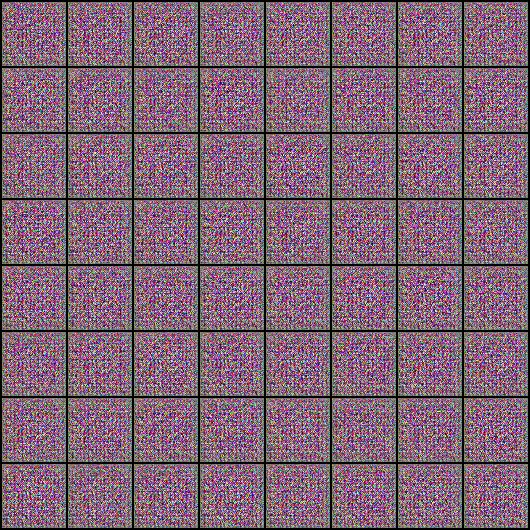

In [35]:
from IPython.display import Image
Image('./generated/generated_image_0001.png')

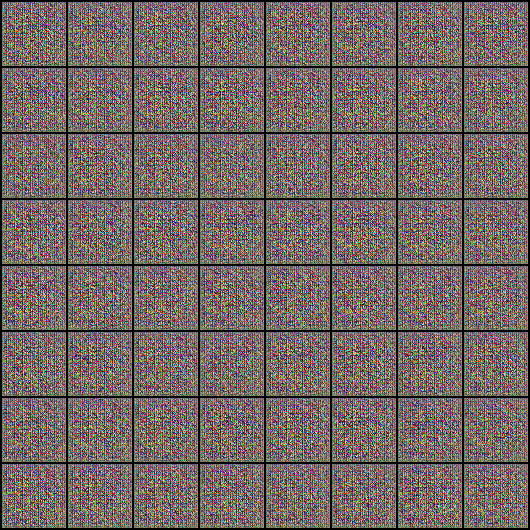

In [36]:
Image('./generated/generated_image_0200.png')